# Compile all target locations

This notebook is based on the previous `create_targets_df.ipynb` and will generate:
- `analysis_path/tracks/targets.csv` and
- `analysis_path/all_info_csv/main_info_append_01.csv`

This notebook compile all target locations that were hand-marked from all trials, and put them in a single dataframe, attached with a depth of -1 m. 

The goal in the previous version was to generate a single csv file in the format expected by Mitchell's `transformation_to_origin.py`. That is not used anymore, but since it's too much work to change everything again, let's just use the old routine here.

## Set paths

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
analysis_path = Path('../data_processed/')
main_csv_path = analysis_path / 'all_info_csv/main_info.csv'
targets_path = analysis_path / 'tracks/target_markers'

## Wrangle filenames

In [3]:
# Assemble path to target marked files
# index_col=0 omitts the extra Unnames column in the dataframe
df_all = pd.read_csv(main_csv_path, index_col=0)

Find out which files were not marked due to other reasons

In [4]:
df_all.columns

Index(['DATE', 'SESSION', 'PERSONNEL', 'TRIAL', 'LEFT', 'RIGHT', 'ANGLE',
       'SPHEROID', 'ASPECT_RATIO', 'SEQUENCE', 'CHOICE', 'WJ_COMMENTS',
       'VIDEO_REVIEW_COMMENTS', 'VIDEO_TIME', 'VIDEO_NUM', 'OTHER_COMMENTS',
       'DARSHAN_COMMENTS', 'VIDEO_FILENAME', 'FRAME_NUM_START',
       'FRAME_NUM_END', 'KAVIN_TRACK_COMMENTS', 'TRACK_CHECKED',
       'TARGETS_CHECKED', 'LED_flash', 'TOUCH_FRAME', 'TRIAL_TO_INCLUDE',
       'TRACK_ISSUES', 'LATE_TURN', 'EYECUP_ISSUE', 'TRACK_USED',
       'hydro_filename', 'hydro_recording_time', 'hydro_time_diff',
       'rough_chirp_time', 'dtag_trial_start_time', 'dtag_trial_end_time',
       'see_chirp_in_dtag', 'dtag_trial_comments', 'dtag_wav_file',
       'DLC_video_trial_label', 'gopro_video', 'DLC_labeled_h5',
       'tap_sync_video_num', 'tap_sync_dtag_start_time',
       'tap_sync_dtag_end_time', 'tap_sync_video_frame', 'tap_sync_comments',
       'tap_sync_time_dtag2video'],
      dtype='object')

### Assemble path to target marker files

In [5]:
df_all['target_marker_filename'] = (df_all['VIDEO_FILENAME'].str[-12:-4] + "_" +
                                    df_all['DATE'].astype(str) +
                                    "_s" + df_all['SESSION'].astype(str) +
                                    "_t" + df_all['TRIAL'].apply('{:0>2}'.format) +
                                    "_xypts.csv")

The `target_marker_filename` assembled above do not work for the trials where the trials happened in the 2nd or the 3rd GoPro video files. Let's fix them below and update the paths to the target marker files.

In [6]:
# Fix filename
fix_name_dict = {
    'GOPR1466_20190625_s1_t00_xypts.csv': 'GOPR1466_20190625_s1_t00_1_xypts.csv', 
    'GP011472_20190627_s1_t08_xypts.csv': 'GOPR1472_20190627_s1_t08_xypts.csv',
    'GP021479_20190701_s2_t03_xypts.csv': 'GP011479_20190701_s2_t03_xypts.csv', 
    'GP011482_20190702_s2_t10_xypts.csv': 'GOPR1482_20190702_s2_t10_xypts.csv', 
    'GP011489_20190704_s3_t12_xypts.csv': 'GOPR1489_20190704_s3_t12_xypts.csv', 
}

for k, v in fix_name_dict.items():
    df_all.loc[df_all['target_marker_filename']==k, 'target_marker_filename'] = v

In [7]:
# Assemble filepath
df_all['target_marker_filepath'] = df_all['target_marker_filename'].\
                                    apply(lambda x: str(Path(targets_path).joinpath(x)))

In [8]:
# Sanity check
df_all['target_marker_filepath'][0]

'../data_processed/tracks/target_markers/GOPR1466_20190625_s1_t00_1_xypts.csv'

### Add info about whether the target marker file actually exist

In [9]:
# Whether target marker file exists
df_all['target_marker_exist'] = df_all['target_marker_filepath'].apply(lambda x: Path(x).is_file())

In [10]:
# Whether target marker file was intentionally skipped due to video condition
df_all['target_marker_checked'] = df_all['TARGETS_CHECKED'].apply(lambda x: x=='x')

In [11]:
# Clean up dataframe before more operation
df_all = df_all.loc[:, ['DATE', 'SESSION', 'TRIAL', 
                        'TRACK_CHECKED', 'TARGETS_CHECKED', 'KAVIN_TRACK_COMMENTS',
                        'target_marker_filename', 'target_marker_filepath', 
                        'target_marker_exist', 'target_marker_checked']]

In [12]:
df_all

,DATE,SESSION,TRIAL,TRACK_CHECKED,TARGETS_CHECKED,KAVIN_TRACK_COMMENTS,target_marker_filename,target_marker_filepath,target_marker_exist,target_marker_checked
0,20190625,1,0,NO,NO,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,False
1,20190625,1,0,x,x,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
2,20190625,1,1,x,x,NaN,GOPR1466_20190625_s1_t01_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
3,20190625,1,2,x,x,NaN,GOPR1466_20190625_s1_t02_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
4,20190625,1,3,x,x,NaN,GOPR1466_20190625_s1_t03_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,8,x,x,NaN,GOPR1489_20190704_s3_t08_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
243,20190704,3,9,x,x,NaN,GOPR1489_20190704_s3_t09_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
244,20190704,3,10,x,x,NaN,GOPR1489_20190704_s3_t10_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True
245,20190704,3,11,x,x,NaN,GOPR1489_20190704_s3_t11_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True


In [13]:
# Target marker files wanted
df_all['file_wanted'] = (df_all['target_marker_exist']) & (df_all['target_marker_checked'])

In [14]:
# List all trials that does NOT have targets info
df_all.loc[df_all['file_wanted']==False, :]

,DATE,SESSION,TRIAL,TRACK_CHECKED,TARGETS_CHECKED,KAVIN_TRACK_COMMENTS,target_marker_filename,target_marker_filepath,target_marker_exist,target_marker_checked,file_wanted
0,20190625,1,0,NO,NO,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,False,False
23,20190625,3,8,NO,NO,glare make markers hard to see near targets,GP011468_20190625_s3_t08_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
67,20190627,2,1,x,NO,glare block bottom target,GP011473_20190627_s2_t01_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
68,20190627,2,2,NO,NO,glare blocks Freja for a long time,GP011473_20190627_s2_t02_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
69,20190627,2,3,NO,NO,glare blocks Freja for a long time,GP011473_20190627_s2_t03_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
70,20190627,2,4,NO,NO,glare blocks Freja for a long time,GP011473_20190627_s2_t04_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
71,20190627,2,5,NO,NO,glare blocks Freja for a long time,GP011473_20190627_s2_t05_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
72,20190627,2,6,x,NO,glare causes some gaps in tracking glare block...,GP011473_20190627_s2_t06_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
77,20190627,2,11,NO,NO,glare blocks Freja for a long time,GP011473_20190627_s2_t11_xypts.csv,../data_processed/tracks/target_markers/GP0114...,False,False,False
147,20190701,3,6,NO,NO,waves and glare too strong,GOPR1480_20190701_s3_t06_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,False,False,False


In [15]:
len(df_all.loc[df_all['file_wanted']==False, :])

10

In [16]:
# Sanity check: all files with file_wanted==True should exist,
# so below should print out nothing
for fpath in df_all.loc[df_all['file_wanted']==True, 'target_marker_filepath'].values:
    if not Path(fpath).is_file():
        print('this file does not exist: ' + Path(fpath).name)

## Assmeble dataframe with target locations

In [17]:
# Get all xy position data, fill in NaN for non-existing trials
xypos_all = []
for trial_idx in df_all.index:
    s = df_all.loc[trial_idx, :]
    if s['file_wanted'] == True:
        xypos = pd.read_csv(s['target_marker_filepath']).dropna(how='all').values.squeeze()
        if xypos.size<4:
            xypos = np.hstack((xypos, np.ones(4-xypos.size) * np.nan))  # pad NaN
    else:
        xypos = np.ones(4) * np.nan
    xypos_all.append(xypos)
xypos_all = np.array(xypos_all)
df_xypos = pd.DataFrame(xypos_all)

In [18]:
# Attach xy positions to the main dataframe
df_all[pd.read_csv(s['target_marker_filepath']).dropna(how='all').columns] = df_xypos

In [19]:
# Sanity check
df_all

,DATE,SESSION,TRIAL,TRACK_CHECKED,TARGETS_CHECKED,KAVIN_TRACK_COMMENTS,target_marker_filename,target_marker_filepath,target_marker_exist,target_marker_checked,file_wanted,pt1_cam1_X,pt1_cam1_Y,pt2_cam1_X,pt2_cam1_Y
0,20190625,1,0,NO,NO,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,False,False,NaN,NaN,NaN,NaN
1,20190625,1,0,x,x,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,303.551789,386.409662,NaN,NaN
2,20190625,1,1,x,x,NaN,GOPR1466_20190625_s1_t01_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,302.271569,392.854390,318.947747,644.229963
3,20190625,1,2,x,x,NaN,GOPR1466_20190625_s1_t02_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,316.677377,402.137785,315.380141,623.033970
4,20190625,1,3,x,x,NaN,GOPR1466_20190625_s1_t03_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,315.938432,394.360814,311.760141,644.245539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,8,x,x,NaN,GOPR1489_20190704_s3_t08_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,291.627729,390.261163,288.263092,630.648188
243,20190704,3,9,x,x,NaN,GOPR1489_20190704_s3_t09_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,269.550265,409.937901,272.012987,652.507495
244,20190704,3,10,x,x,NaN,GOPR1489_20190704_s3_t10_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,265.892256,414.520343,265.892256,657.089936
245,20190704,3,11,x,x,NaN,GOPR1489_20190704_s3_t11_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,266.569745,413.912206,268.569745,654.426124


In [20]:
# Fix column names
df_all.rename(columns={'pt1_cam1_X': 'TOP_OBJECT_X',
                       'pt1_cam1_Y': 'TOP_OBJECT_Y',
                       'pt2_cam1_X': 'BOTTOM_OBJECT_X',
                       'pt2_cam1_Y': 'BOTTOM_OBJECT_Y',}, inplace=True)

In [21]:
df_all

,DATE,SESSION,TRIAL,TRACK_CHECKED,TARGETS_CHECKED,KAVIN_TRACK_COMMENTS,target_marker_filename,target_marker_filepath,target_marker_exist,target_marker_checked,file_wanted,TOP_OBJECT_X,TOP_OBJECT_Y,BOTTOM_OBJECT_X,BOTTOM_OBJECT_Y
0,20190625,1,0,NO,NO,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,False,False,NaN,NaN,NaN,NaN
1,20190625,1,0,x,x,NaN,GOPR1466_20190625_s1_t00_1_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,303.551789,386.409662,NaN,NaN
2,20190625,1,1,x,x,NaN,GOPR1466_20190625_s1_t01_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,302.271569,392.854390,318.947747,644.229963
3,20190625,1,2,x,x,NaN,GOPR1466_20190625_s1_t02_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,316.677377,402.137785,315.380141,623.033970
4,20190625,1,3,x,x,NaN,GOPR1466_20190625_s1_t03_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,315.938432,394.360814,311.760141,644.245539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,8,x,x,NaN,GOPR1489_20190704_s3_t08_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,291.627729,390.261163,288.263092,630.648188
243,20190704,3,9,x,x,NaN,GOPR1489_20190704_s3_t09_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,269.550265,409.937901,272.012987,652.507495
244,20190704,3,10,x,x,NaN,GOPR1489_20190704_s3_t10_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,265.892256,414.520343,265.892256,657.089936
245,20190704,3,11,x,x,NaN,GOPR1489_20190704_s3_t11_xypts.csv,../data_processed/tracks/target_markers/GOPR14...,True,True,True,266.569745,413.912206,268.569745,654.426124


In [22]:
# Add Z dimension: assume 1 meter depth
df_all['TOP_OBJECT_Z'] = -1.0
df_all['BOTTOM_OBJECT_Z'] = -1.0

In [23]:
df_all.rename(columns={'target_marker_filename': 'TARGETS_CSV_FILENAME'}, inplace=True)

In [24]:
# Select columns expected by Mitchell's script
df_targets = df_all.loc[:, ['DATE', 'SESSION', 'TRIAL', 'TARGETS_CSV_FILENAME', 
                            'TOP_OBJECT_X', 'TOP_OBJECT_Y', 'TOP_OBJECT_Z',
                            'BOTTOM_OBJECT_X', 'BOTTOM_OBJECT_Y', 'BOTTOM_OBJECT_Z']]

In [25]:
df_targets

,DATE,SESSION,TRIAL,TARGETS_CSV_FILENAME,TOP_OBJECT_X,TOP_OBJECT_Y,TOP_OBJECT_Z,BOTTOM_OBJECT_X,BOTTOM_OBJECT_Y,BOTTOM_OBJECT_Z
0,20190625,1,0,GOPR1466_20190625_s1_t00_1_xypts.csv,NaN,NaN,-1.0,NaN,NaN,-1.0
1,20190625,1,0,GOPR1466_20190625_s1_t00_1_xypts.csv,303.551789,386.409662,-1.0,NaN,NaN,-1.0
2,20190625,1,1,GOPR1466_20190625_s1_t01_xypts.csv,302.271569,392.854390,-1.0,318.947747,644.229963,-1.0
3,20190625,1,2,GOPR1466_20190625_s1_t02_xypts.csv,316.677377,402.137785,-1.0,315.380141,623.033970,-1.0
4,20190625,1,3,GOPR1466_20190625_s1_t03_xypts.csv,315.938432,394.360814,-1.0,311.760141,644.245539,-1.0
...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,8,GOPR1489_20190704_s3_t08_xypts.csv,291.627729,390.261163,-1.0,288.263092,630.648188,-1.0
243,20190704,3,9,GOPR1489_20190704_s3_t09_xypts.csv,269.550265,409.937901,-1.0,272.012987,652.507495,-1.0
244,20190704,3,10,GOPR1489_20190704_s3_t10_xypts.csv,265.892256,414.520343,-1.0,265.892256,657.089936,-1.0
245,20190704,3,11,GOPR1489_20190704_s3_t11_xypts.csv,266.569745,413.912206,-1.0,268.569745,654.426124,-1.0


## Sanity check of results

In [26]:
import matplotlib.pyplot as plt

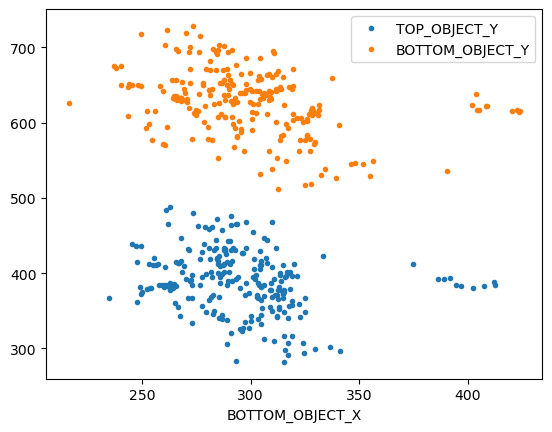

In [27]:
fig,ax = plt.subplots(1,1)
df_targets.plot(ax=ax, x='TOP_OBJECT_X', y='TOP_OBJECT_Y', marker='.', linestyle='none')
df_targets.plot(ax=ax, x='BOTTOM_OBJECT_X', y='BOTTOM_OBJECT_Y', marker='.', linestyle='none')
plt.show()

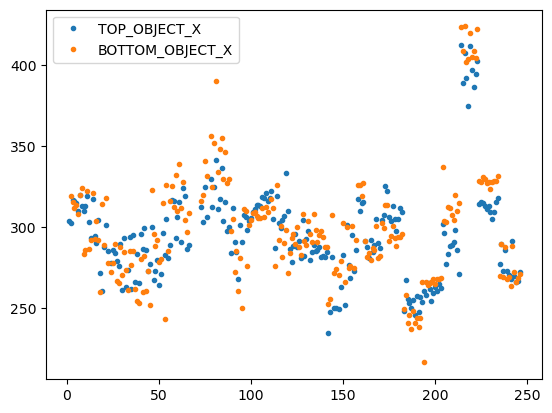

In [28]:
fig,ax = plt.subplots(1,1)
df_targets['TOP_OBJECT_X'].plot(ax=ax, marker='.', linestyle='none', label='TOP_OBJECT_X')
df_targets['BOTTOM_OBJECT_X'].plot(ax=ax, marker='.', linestyle='none', label='BOTTOM_OBJECT_X')
plt.legend()
plt.show()

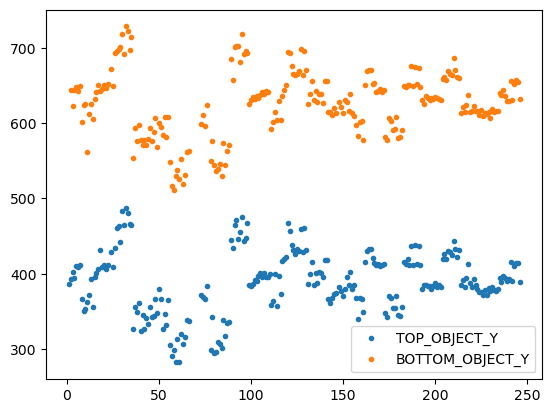

In [29]:
fig,ax = plt.subplots(1,1)
df_targets['TOP_OBJECT_Y'].plot(ax=ax, marker='.', linestyle='none', label='TOP_OBJECT_Y')
df_targets['BOTTOM_OBJECT_Y'].plot(ax=ax, marker='.', linestyle='none', label='BOTTOM_OBJECT_Y')
plt.legend()
plt.show()

## Save results

In [30]:
rows_without_nan = df_targets.notna().all(axis=1)

In [31]:
df_targets.dropna(how='any', inplace=True)  # Drop row if any of the xy positions are NaN

In [32]:
df_targets

,DATE,SESSION,TRIAL,TARGETS_CSV_FILENAME,TOP_OBJECT_X,TOP_OBJECT_Y,TOP_OBJECT_Z,BOTTOM_OBJECT_X,BOTTOM_OBJECT_Y,BOTTOM_OBJECT_Z
2,20190625,1,1,GOPR1466_20190625_s1_t01_xypts.csv,302.271569,392.854390,-1.0,318.947747,644.229963,-1.0
3,20190625,1,2,GOPR1466_20190625_s1_t02_xypts.csv,316.677377,402.137785,-1.0,315.380141,623.033970,-1.0
4,20190625,1,3,GOPR1466_20190625_s1_t03_xypts.csv,315.938432,394.360814,-1.0,311.760141,644.245539,-1.0
5,20190625,1,4,GOPR1466_20190625_s1_t04_xypts.csv,314.866282,410.306210,-1.0,313.730960,647.654532,-1.0
6,20190625,1,5,GOPR1466_20190625_s1_t05_xypts.csv,309.969216,408.364026,-1.0,308.327401,642.710921,-1.0
...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,8,GOPR1489_20190704_s3_t08_xypts.csv,291.627729,390.261163,-1.0,288.263092,630.648188,-1.0
243,20190704,3,9,GOPR1489_20190704_s3_t09_xypts.csv,269.550265,409.937901,-1.0,272.012987,652.507495,-1.0
244,20190704,3,10,GOPR1489_20190704_s3_t10_xypts.csv,265.892256,414.520343,-1.0,265.892256,657.089936,-1.0
245,20190704,3,11,GOPR1489_20190704_s3_t11_xypts.csv,266.569745,413.912206,-1.0,268.569745,654.426124,-1.0


In [33]:
df_targets.to_csv(Path(analysis_path).joinpath('tracks/targets.csv'))

## Append column to main dataframe

In [34]:
df_main = pd.read_csv(main_csv_path, index_col=0)

In [35]:
df_main[['target_marker_exist', 'target_marker_checked']] = \
    df_all.loc[:, ['target_marker_exist', 'target_marker_checked']]

In [36]:
df_main['target_position_assembled_in_csv'] = rows_without_nan

In [37]:
df_main['target_csv_filename'] = df_targets['TARGETS_CSV_FILENAME']

In [38]:
df_main

,DATE,SESSION,PERSONNEL,TRIAL,LEFT,RIGHT,ANGLE,SPHEROID,ASPECT_RATIO,SEQUENCE,...,tap_sync_video_num,tap_sync_dtag_start_time,tap_sync_dtag_end_time,tap_sync_video_frame,tap_sync_comments,tap_sync_time_dtag2video,target_marker_exist,target_marker_checked,target_position_assembled_in_csv,target_csv_filename
0,20190625,1,"WJ, ML",0,T,X,1,X,0.0,1,...,3,0:50.000,0:52.000,"169, 186, 200",NaN,-44.734711,True,False,False,NaN
1,20190625,1,"WJ, ML",0,T,X,1,X,0.0,1,...,3,0:50.000,0:52.000,"169, 186, 200",NaN,-44.734711,True,True,False,NaN
2,20190625,1,"WJ, ML",1,T,C,1,L,2.9,1,...,3,0:50.000,0:52.000,"169, 186, 200",NaN,-44.734711,True,True,True,GOPR1466_20190625_s1_t01_xypts.csv
3,20190625,1,"WJ, ML",2,C,T,1,L,2.9,1,...,3,0:50.000,0:52.000,"169, 186, 200",NaN,-44.734711,True,True,True,GOPR1466_20190625_s1_t02_xypts.csv
4,20190625,1,"WJ, ML",3,T,C,1,L,2.9,1,...,3,0:50.000,0:52.000,"169, 186, 200",NaN,-44.734711,True,True,True,GOPR1466_20190625_s1_t03_xypts.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,20190704,3,ML,8,T,C,1,M,1.3,24,...,5,0:12.000,0:16.000,"997, 1008, 1019, 1053, 1066","use only the 2nd and 3rd bout, because cannot ...",20.514301,True,True,True,GOPR1489_20190704_s3_t08_xypts.csv
243,20190704,3,ML,9,C,T,3,M,1.3,24,...,5,0:12.000,0:16.000,"997, 1008, 1019, 1053, 1066","use only the 2nd and 3rd bout, because cannot ...",20.514301,True,True,True,GOPR1489_20190704_s3_t09_xypts.csv
244,20190704,3,ML,10,T,C,3,M,1.3,24,...,5,0:12.000,0:16.000,"997, 1008, 1019, 1053, 1066","use only the 2nd and 3rd bout, because cannot ...",20.514301,True,True,True,GOPR1489_20190704_s3_t10_xypts.csv
245,20190704,3,ML,11,T,C,3,M,1.3,24,...,5,0:12.000,0:16.000,"997, 1008, 1019, 1053, 1066","use only the 2nd and 3rd bout, because cannot ...",20.514301,True,True,True,GOPR1489_20190704_s3_t11_xypts.csv


In [39]:
df_main.to_csv(Path(analysis_path).joinpath('all_info_csv/main_info_append_01.csv'))